In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import dm_prior_fcns
import bh_prior_fcns
import matplotlib as mpl

In [2]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc

cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
plt.rcParams['font.serif']=cmfont.get_name()
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.size" : fontsize,
          "text.usetex" : False,
          "mathtext.fontset" : "cm",
          "font.family" : "serif",
          "font.serif" : [cmfont.get_name()]}
plt.rcParams['axes.unicode_minus']=False
plt.rcParams.update(params)

In [3]:
priors = dm_prior_fcns.DM_priors()
priors_bh = bh_prior_fcns.BH_priors()

In [4]:
def rho_cyl(r, l, b, r0 = 8.0):
    """
    Returns the distance to the galactic center in kpc given the 
    distance to the solar system and galactic coordinates in cylinrical
    coordinate.
    
    Parameters
    r[array]: distance to the solar system in kpc.
    l[flaot]: galactic longtitude in degrees.
    b[float]: galactic lattitude in degrees.
    r0[float]: distance from the solar system to galactic center in kpc
               (default 8.0)
    """
    l = l*const.degree
    b = b*const.degree
    return np.sqrt(r0**2 + (r*np.cos(b))**2 - 2*r*r0*np.cos(l)*np.cos(b))


def theta_cyl(r, l, b, r0 = 8.0):
    rho = rho_cyl(r, l, b, r0)
    r = r*np.cos(b*const.degree)
    cos = (rho**2 + r0**2 - r**2)/(2*rho*r0)
    if cos > 1:
        cos = 1
    theta = np.arccos(cos)/const.degree
    #print(cos)
    theta = 180 - theta
    if l > 180:
        theta = 360 - theta
    return theta


def rot_cyl2cart(theta):
    theta = theta*const.degree
    r_mat = np.array([[np.cos(theta), -np.sin(theta), 0],
                      [np.sin(theta),  np.cos(theta), 0],
                      [            0,              0, 1]])
    return r_mat


def rot_cart2galactic(l, b):
    l = l*const.degree
    b = b*const.degree
    r_mat = np.array([[ np.cos(b)*np.cos(l),  np.cos(b)*np.sin(l), np.sin(b)],
                      [          -np.sin(l),            np.cos(l),         0],
                      [-np.sin(b)*np.cos(l), -np.sin(b)*np.sin(l), np.cos(b)]])
    return r_mat


def pm_radec2lb(vra, vdec, l, b):
    """
    Returns the propoer motion in the direction of (RA, DEC) from
    the direction of (l, b).
    
    pm_lb[array]: velocity in Cartesian coordinate.
    l[flaot]: galactic longtitude in degrees.
    b[float]: galactic lattitude in degrees.
    ra[flaot]: right ascension in degrees.
    dec[float]: declination in degrees.
    """
    r = hp.rotator.Rotator(coord = ('G', 'C'))
    pm = np.array([vra, vdec])
    dec_G = 27.12825*const.degree
    ra_G = 192.85948*const.degree
    l = l*const.degree
    b = b*const.degree
    
    dec, ra = r(np.pi/2 - b, l)
    #print(ra, dec)
    dec = np.pi/2 - dec
    #print(ra, dec)
    cos = (np.sin(dec_G) - np.sin(dec)*np.sin(b))/np.cos(dec)/np.cos(b)
    sin = np.sin(ra - ra_G)*np.cos(dec_G)/np.cos(b)
    r_matrix = np.array([[ cos, sin],
                         [-sin, cos]])
    
    #print(cos**2 + sin**2)
    
    return r_matrix.dot(pm)

In [5]:
r = hp.rotator.Rotator(coord = ('G', 'C'))

In [6]:
def prior_cyl(vr, vphi, vz, sr = 77.5, sphi = 72.5, sz = 70):
    v = np.array([vr, vphi + 220, vz])
    inv_cov = np.diag([1/sr**2, 1/sphi**2, 1/sz**2])
    return 1/(2*np.pi)**(3/2)/(sr*sphi*sz)*np.exp(-v.dot(inv_cov.dot(v))/2)


def prior_cart(vx, vy, vz, r, l, b, sr = 77.5, sphi = 72.5, sz = 70, 
               sun_rot = np.array([0, 220, 0]),
               sun_pec = np.array([11.1, 12.24, 7.25])):
    
    diag_cov = np.diag([1/sr**2, 1/sphi**2, 1/sz**2])
    
    theta = theta_cyl(r, l, b)
    r_mat = rot_cyl2cart(theta)
    
    v = np.array([vx, vy, vz])
    v0 = r_mat.dot(np.array([0, -220, 0]))
    v_sun = sun_rot + sun_pec
    
    v = v - v0 + v_sun
    
    inv_cov = r_mat.dot(diag_cov.dot(r_mat.T))
    chi_sq = v.dot(inv_cov.dot(v))
    
    return 1/(2*np.pi)**(3/2)/(sr*sphi*sz)*np.exp(-chi_sq/2)


def prior_galactic(vr, vl, vb, r, l, b, sr = 77.5, sphi = 72.5, sz = 70, 
               sun_rot = np.array([0, 220, 0]),
               sun_pec = np.array([11.1, 12.24, 7.25])):
    
    diag_cov = np.diag([1/sr**2, 1/sphi**2, 1/sz**2])
    
    theta = theta_cyl(r, l, b)
    r1_mat = rot_cyl2cart(theta)
    r2_mat = rot_cart2galactic(l, b)
    
    v = np.array([vr, vl, vb])
    v0 = r2_mat.dot(r1_mat.dot(np.array([0, -220, 0])))
    v_sun = r2_mat.dot(sun_rot + sun_pec)
    
    v = v - v0 + v_sun
    
    inv_cov = r1_mat.dot(diag_cov.dot(r1_mat.T))
    inv_cov = r2_mat.dot(inv_cov.dot(r2_mat.T))
    chi_sq = v.dot(inv_cov.dot(v))
    
    return 1/(2*np.pi)**(3/2)/(sr*sphi*sz)*np.exp(-chi_sq/2)


def prior_lb(vl, vb, r, l, b, sr = 77.5, sphi = 72.5, sz = 70, 
               sun_rot = np.array([0, 220, 0]),
               sun_pec = np.array([11.1, 12.24, 7.25])):
    
    diag_cov = np.diag([1/sr**2, 1/sphi**2, 1/sz**2])
    
    theta = theta_cyl(r, l, b)
    r1_mat = rot_cyl2cart(theta)
    r2_mat = rot_cart2galactic(l, b)
    
    v = np.array([vl, vb])
    v0 = r2_mat.dot(r1_mat.dot(np.array([0, -220, 0])))
    v_sun = r2_mat.dot(sun_rot + sun_pec)
    
    v = v - (v0 - v_sun)[1:]
    
    inv_cov = r1_mat.dot(diag_cov.dot(r1_mat.T))
    inv_cov = r2_mat.dot(inv_cov.dot(r2_mat.T))
    
    reduced_cov = np.zeros((2,2))
    reduced_cov[0,0] = inv_cov[1,1] - inv_cov[0,1]**2/inv_cov[0,0]
    reduced_cov[1,1] = inv_cov[2,2] - inv_cov[0,2]**2/inv_cov[0,0]
    reduced_cov[0,1] = inv_cov[1,2] - inv_cov[0,1]*inv_cov[0,2]/inv_cov[0,0]
    reduced_cov[1,0] = reduced_cov[0,1]
    
    chi_sq = v.dot(reduced_cov.dot(v))
    
    return 1/(2*np.pi)/(sr*sphi*sz)*np.exp(-chi_sq/2)/np.sqrt(inv_cov[0,0])


def prior_radec(pmra, pmdec, r, l, b, sr = 77.5, sphi = 72.5, sz = 70, 
               sun_rot = np.array([0, 220, 0]),
               #sun_pec = np.array([0, 0, 0])):
               sun_pec = np.array([11.1, 12.24, 7.25])):
    
    tau = r*const.parsec/const.Julian_year*const.arcsec/1000
    #print(tau)
    pm = pm_radec2lb(pmra, pmdec, l, b)*tau
    vl = pm[0]
    #print(vl)
    vb = pm[1]
    
    return prior_lb(vl, vb, r, l, b, sr, sphi, sz, sun_rot, sun_pec)*tau**2
    #return 1/(2*np.pi)/(sr*sphi*sz)*np.exp(-chi_sq/2)/np.sqrt(inv_cov[0,0])
    

In [7]:
l = 270
b = 0
r = 1

contour = np.zeros((81,81))

x = np.arange(-40, 41, 1)
y = np.arange(-40, 41, 1)
d = np.arange(.1, 5.1, 0.1)
for i in range(len(x)):
    for j in range(len(y)):
        contour[i,j] = prior_radec(x[i], y[j], r, l, b)
        #print(d[j])
            #print(contour[i,j])

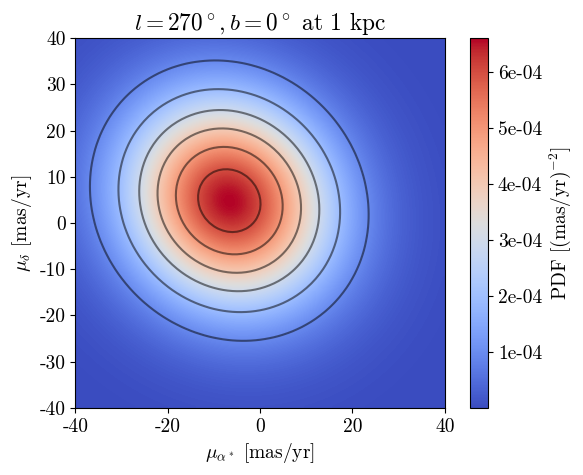

In [8]:
plt.contour(x, y, contour.T, colors = 'black', alpha = 0.5)
#plt.colorbar()
plt.xlabel(r'$\mu_{\alpha^*}$ [mas/yr]')
plt.ylabel(r'$\mu_\delta$ [mas/yr]')
plt.title(f'$l = {l}^\circ, b = {b}^\circ$ at {r} kpc')
plt.imshow(contour.T, interpolation='bilinear', origin='lower',
               cmap='coolwarm',extent=(-40, 40, -40, 40))
plt.colorbar(format = '%.e', label = 'PDF [(mas/yr)$^{-2}$]')
plt.savefig(f'pm_distance_contour_r{r}_l{l}_b{b}.pdf', bbox_inches = 'tight')